In [1]:
# RNN on sine wave, using bp on weight matrix, enforce Dale's law
import sys
sys.path.append("../../model")
import numpy as np
from rnn_sin2 import RNN
import matplotlib.pyplot as plt
import json
import torch
import torch.nn as nn
import seaborn as sns
from tqdm.notebook import tqdm

## Loading Trained Weights

In [2]:
num_nodes = 16
filedir = "../weights/"
filename = "SIN2_wt_" + str(num_nodes) + "_nodes.json"
filepath = filedir + filename
with open(filepath) as f:
    weight_history = json.load(f)

In [3]:
weight_history.keys()

dict_keys(['trained gain', 'trained shift', 'trained weights', 'connectivity matrix', 'input weights', 'output weights', 'losses', 'init_weight'])

In [4]:
gains = np.array(weight_history['trained gain'])
shifts = np.array(weight_history['trained shift'])
weight_matrix = np.array(weight_history['trained weights'])
connectivity_matrix = np.array(weight_history['connectivity matrix'])
input_weight_matrix = np.array(weight_history['input weights'])
output_weight_matrix = np.array(weight_history['output weights'])
losses = np.array(weight_history['losses'])

# test oja
# weight_sums = np.array(weight_history['weight_sums'])
# gain_changes = np.array(weight_history['gain_changes'])

In [5]:
weight_matrix

array([[ 0.00000000e+00,  5.17558098e-01,  2.96915859e-01,
         1.20971000e+00,  1.07156050e+00,  2.31373239e+00,
         1.93550599e+00,  8.91530454e-01, -8.26152205e-01,
        -4.79205549e-01, -1.30827403e+00, -2.39428449e+00,
        -2.96535015e-01, -8.12595069e-01, -1.21740055e+00,
        -1.09424853e+00],
       [ 5.77149868e-01,  0.00000000e+00,  7.36265108e-02,
         7.73302078e-01,  1.64897740e+00,  1.31922805e+00,
         1.18408370e+00,  5.85043132e-01, -1.25484014e+00,
        -9.85873520e-01,  0.00000000e+00, -1.20584822e+00,
        -1.71312332e-01, -8.13408792e-01, -2.80562669e-01,
        -3.91142100e-01],
       [ 8.47919345e-01,  9.92772222e-01, -0.00000000e+00,
         1.52898327e-01,  1.35756469e+00,  3.97923112e-01,
         1.91761923e+00,  7.75054395e-01, -3.46119165e-01,
        -5.99554121e-01, -6.83264434e-01, -1.41061974e+00,
         0.00000000e+00, -3.28792155e-01, -4.19905722e-01,
        -2.08145857e+00],
       [ 3.43026876e-01,  8.24628651e

In [6]:
output_weight_matrix

array([[ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1., -1., -1., -1., -1.,
        -1., -1., -1.]])

In [7]:
np.max(weight_matrix)

2.6851630210876465

Text(0.5, 1.0, 'Weight matrix')

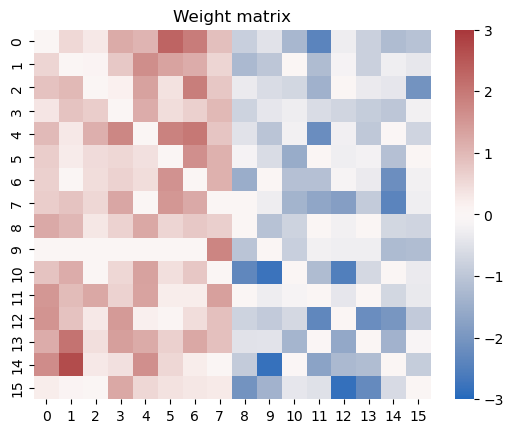

In [8]:
sns.heatmap(weight_matrix, vmax=3, vmin=-3, cmap='vlag')
plt.title('Weight matrix')
# plt.savefig('fig/0122_SIN2_wt_weight_matrix.png')

In [9]:
excite_weights = weight_matrix * (weight_matrix > 0)
# sns.heatmap(excite_weights, vmax=1, vmin=-1, cmap='vlag')

In [10]:
np.sum(excite_weights)

97.23634585784748

In [11]:
inhibit_weights = weight_matrix * (weight_matrix < 0)
np.sum(inhibit_weights)

-103.86176435300149

In [12]:
# estimate oja's alpha
1 / np.linalg.norm(excite_weights, None)**2

0.008331195586761703

## Defining Network

In [13]:
time_constant = 100 #ms
timestep = 10 #ms
ndata = 400
time = ndata * timestep #ms
num_inputs = 1
num_nodes = 16
init_activations = np.zeros((num_nodes, 1))

network = RNN(weight_matrix, connectivity_matrix, init_activations, gains, shifts, input_weight_matrix, output_weight_matrix, 
                time_constant = time_constant, timestep = timestep, 
                # output_nonlinearity=nn.Sigmoid()
                )

100%|██████████| 400/400 [00:00<00:00, 13026.80it/s]

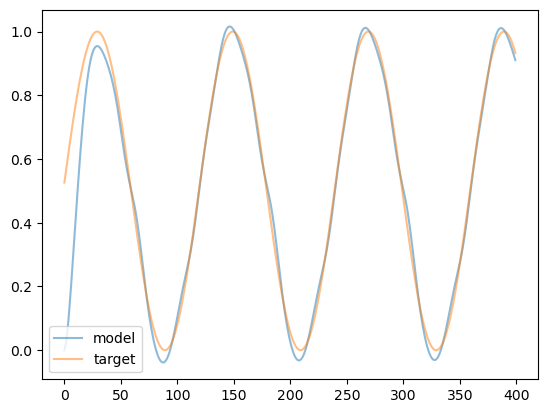

In [14]:
time_points = np.arange(ndata).reshape(-1, 1)
inputs = (1 + np.sin(time_points/60*np.pi))/2
targets = (1 + np.sin((time_points+1)/60*np.pi))/2
inputs = inputs.reshape(-1, 1)
targets = targets.reshape(-1, 1)

outputs, activations = network.simulate(time, torch.tensor(inputs).float())
fig, ax = plt.subplots()
plt.plot(time_points, outputs.detach().numpy(), alpha=0.5, label='model')
# plt.plot(time_points, inputs)
plt.plot(time_points, targets, alpha=0.5, label='target')
# plt.ylim([0,1])
plt.legend()
# plt.savefig("fig/sin_oja_train.png")

100%|██████████| 300/300 [00:00<00:00, 8943.52it/s]


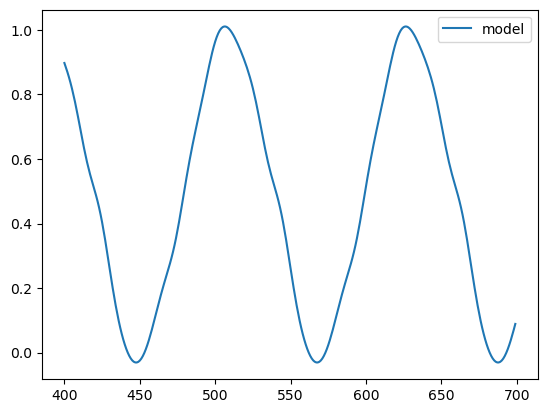

In [15]:
time_pred = 3000
time_points_pred = np.arange(400,700).reshape(-1, 1)
inputs_pred = (1 + np.sin(time_points_pred/60*np.pi))/2

outputs_pred, activations_pred = network.simulate(time_pred, torch.tensor(inputs_pred).float())
fig, ax = plt.subplots()
plt.plot(time_points_pred, outputs_pred.detach().numpy(), label='model')
# plt.ylim([0,1])
plt.legend()
# plt.savefig("fig/sin_oja_pred.png")

(0.0, 0.1)

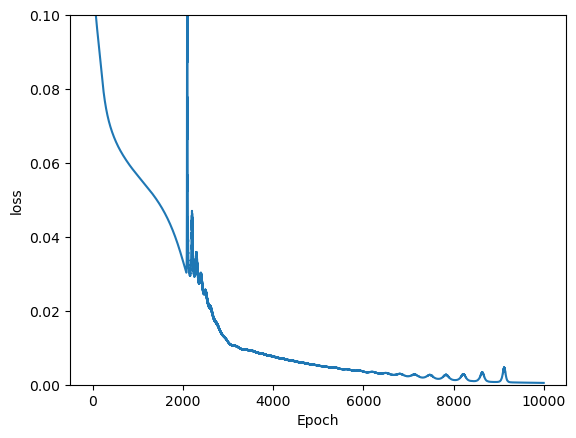

In [16]:
plt.plot(np.arange(len(losses)), losses)
plt.xlabel("Epoch")
plt.ylabel("loss")
plt.ylim([0,0.1])
# plt.savefig("fig/sin_oja_loss.png")

Text(50.722222222222214, 0.5, 'Node')

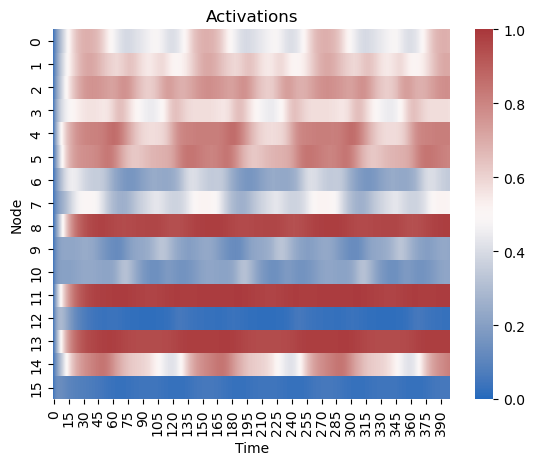

In [17]:
activations_t = activations.detach().numpy().T
sns.heatmap(activations_t, cmap='vlag', vmax=1, vmin=0)
plt.title('Activations')
plt.xlabel('Time')
plt.ylabel('Node')
# plt.savefig('fig/0221_SIN2_bphcppt_activations.png')